## Hopfield network from notebook notes


In [28]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import networkx as nx
import itertools

In [29]:
def G(n, seed, probability, negative_p, sparse=True, w=None, r=True):
    """
    Generates a seeded random graph with n nodes. 
    probability between 0 and 1 to increase odds.
    negative_p is the probability of a negative weight.
    sparse means if we want a sparse or dense graph.
    w is the weight of the edges if wanted.
    r means if we want random weights or not.
    """
    random.seed(seed)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i, j in itertools.combinations(G.nodes, 2):
        if sparse == True:
            if random.random() > (1 - probability):
                if r == True:
                    G.add_edge(i, j, weight=random.random())
                    # realized that does not cover negative weights, added:
                    #randomly make the weight negative or positive
                else:
                    G.add_edge(i, j, weight=w)
        if sparse == False:
            #Means we want a dense network, so
            if r == True:
                G.add_edge(i, j, weight=random.random())
            else:
                G.add_edge(i, j, weight=w)
    
    adjacency_matrix = nx.adjacency_matrix(G)
    for i, j in itertools.combinations(G.nodes, 2):
        if random.random() > (1 - negative_p):
            adjacency_matrix[i, j] = -1 * adjacency_matrix[i, j]

    return G, adjacency_matrix

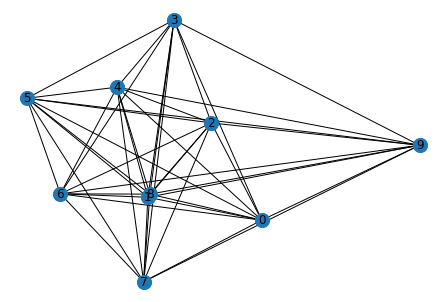

In [30]:
def plot_network(G):
    """
    Plots the graph G.
    """
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=200)
    if len(G.nodes) < 10:
            edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.show()

GG , h = G(10, random.random(), 1, 0.5, sparse=True, r=True)
plot_network(GG)

In [31]:
# Weight matrix from graph edges
weights = h.todense()
weights = np.array(weights)

In [32]:
weights[0]

array([ 0.        , -0.21534841, -0.57027417, -0.73032134,  0.4325866 ,
       -0.37129167, -0.62401908, -0.35011583, -0.50857077,  0.35232451])

In [47]:
# Hopfield network according to shorturl.at/fvGK4
# We are not randomly selecting nodes, but iterating through the list
# Random choice could have better convergence, unsure.
state = np.ones((len(GG.nodes)))
satisfied = [False] * len(GG.nodes)
network_satisfied = False
memory = []
memory_of_memory = []
f = 0
k = 0
while network_satisfied == False:
    # If most nodes are satisfied, break the loop and return state:
    if sum(satisfied) > len(GG.nodes)/2:
        break
    try:
        if satisfied[f] == False:
            for i in weights[f]:
                try:
                    if (i * state[0] * state[k] > 0):
                        #Edge is wrong, flip it
                        state[k] = -1 * state[k]
                        memory.append(i * state[0] * state[k])
                        k += 1
                    else:
                        #Edge is correct
                        memory.append(i * state[0] * state[k])
                        k += 1
                except IndexError:
                    break
    except IndexError:
        f = 0

    if satisfied == True:
        network_satisfied = True
        print("Network is satisfied")

    if sum(memory) <= 0 and memory != []:
        satisfied[f] = True
        memory_of_memory.append(memory)
        memory = []
        print("Node" + str(f) + " is satisfied")
        f += 1
        k = 0
    else:
        print("Node" + str(f) + " is not satisfied")
        satisfied[f] = False
        memory_of_memory.append(memory)
        memory = []
        f += 1
        k = 0

print(state)

# Next, need to check if it is stable or not.


Node0 is satisfied
Node1 is satisfied
Node2 is satisfied
Node3 is satisfied
Node4 is satisfied
Node5 is satisfied
[-1.  1.  1.  1.  1. -1. -1.  1.  1.  1.]


In [48]:
def plot_state_on_network(G, x):
    """
    Plots the maximum cut of a graph on a network plot.
    """
    # Plot the maximum cut as node states, and the state of the nodes as node colors
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=200)
    #Update the node colors based on the dense adjacency matrix
    node_colors = []
    for i in range(len(x)):
        if x[i] == -1:
                node_colors.append('red')
        else:
                node_colors.append('blue')
    nx.draw_networkx_nodes(G, pos, nodelist=range(len(x)), node_color=node_colors, node_size=200)    
    # Display the edge values (for toy problems)
    if len(G.nodes) < 10:
            edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.show()

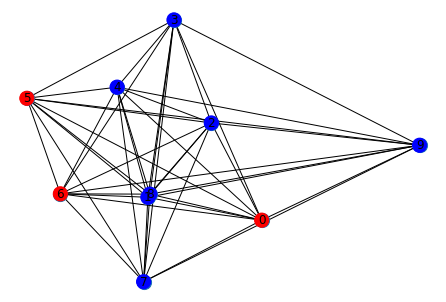

In [49]:
h = state
plot_state_on_network(GG, h)

In [50]:
# Cost of the network after hopfield
cost = 0
for i in range(n):
    for j in range(n):
        cost = cost + w[i,j]*h[i]*(1-h[j])
print(cost)
cost = 0

13.524241551759713


In [37]:
# But that is just the network solution and not the optimal maxcut
# We need to map the weights and the overall network to
# the maxcut problem.

In [51]:
#Solving maxcut via brute force
n = 10
w = weights
best_cost_brute = 0
print_everything = False

for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    if print_everything: 
        print('case = ' + str(x)+ ' cost = ' + str(cost))


print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))


Best solution = [0, 1, 0, 0, 0, 1, 1, 1, 0, 1] cost = 13.816140473534563


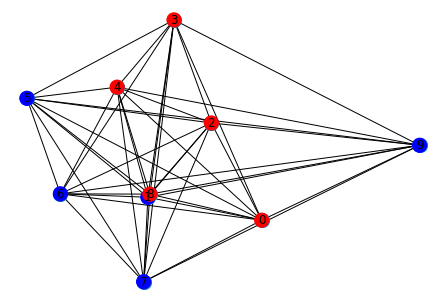

In [52]:
xbest_brute = [-1 if i == 0 else i for i in xbest_brute]
plot_state_on_network(GG, xbest_brute)

In [ ]:
# Using the half-satisfied method, I got better results this time around
# With a cost of 13.53 with the hopfield network
# And a cost of 13.82 with the brute force method